## 1. Installing needed libraries

In [1]:
!pip install openpyxl
!pip install PyArabic
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git &> /dev/null
!pip install emoji 
!pip install Arabic-Stopwords
!pip install tkseem
!pip install tnkeeh
!pip3 install fr-word-segment
!pip install pyspellchecker

     |████████████████████████████████| 242 kB 804 kB/s            
     |████████████████████████████████| 353 kB 780 kB/s            
     |████████████████████████████████| 30.9 MB 890 kB/s            
     |████████████████████████████████| 311 kB 889 kB/s            
     |████████████████████████████████| 243 kB 14.8 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six

## 2. Imports

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from keras.preprocessing.text import Tokenizer

import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from fastai.text.all import *

import sklearn
import regex as re
from unicodedata import normalize

import torch
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.optim.lr_scheduler import CyclicLR
from torchvision import models

from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score
import os
import gensim


# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GRU,MaxPooling1D,GlobalMaxPooling1D,GlobalAveragePooling1D,Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras import callbacks
from keras.utils.vis_utils import plot_model

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer 
from sklearn.metrics import roc_auc_score, accuracy_score,roc_curve, auc, plot_confusion_matrix, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
import emoji
from keras.models import Model
import seaborn as sn
import pyarabic.araby as ar
import tkseem as tk
import tnkeeh as tn
from nltk.stem.isri import ISRIStemmer
from spellchecker import SpellChecker
from wordsegment import load,segment
from keras.layers.merge import Concatenate
import tensorflow as tf
load()

## 3. Loading Data

In [3]:
df_ar = pd.read_csv('/kaggle/input/twitter/ar_dataset.csv')
df_ar2 = pd.read_excel('/kaggle/input/twitter/arr.xlsx')

df_fr = pd.read_csv('/kaggle/input/twitter/fr_dataset.csv')
df_fr2 = pd.read_csv('/kaggle/input/twitter/french_tweets.csv')

## 4. Exploring data

### 4.1 French Dataset

#### 4.1.1 Main dataset

In [4]:
df_fr.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,rt @user personnage ainsi q tte la clique gauchiste deguise 1 macronistes !!ont ttes ls qualites requises qui ont etaient inculq,abusive,direct,shock,origin,other
1,2,@user @user @user bah oui t'as raison l'autre c'est un mongol.,offensive,indirect,shock,other,individual
2,3,moi j'ai personne à qui m'adresser pour réclamer. le voisin c'est un attardé puant et bruyant dans les administrat… @url,hateful,direct,anger_confusion_sadness_fear_disgust,other,women
3,4,@user @user c...est vrai que les anchois sont aller sur la lune et invente de million de technologie !,normal,indirect,indifference,other,other
4,5,eh les renois faut se réveiller la @url,normal,direct,sadness,origin,african_descent


In [5]:
df_fr.describe()

,HITId
count,4014.000000
mean,2007.500000
std,1158.886319
min,1.000000
25%,1004.250000
50%,2007.500000
75%,3010.750000
max,4014.000000


In [6]:
print('Size of the dataset:')
len(df_fr)

Size of the dataset:


4014

In [7]:
#test if the data contains null values
print('Nan value',df_fr.isnull().sum())

Nan value HITId                  0
tweet                  0
sentiment              0
directness             0
annotator_sentiment    0
target                 0
group                  0
dtype: int64


In [8]:
#take a look at the column of the dataframe to see the features
df_fr.columns

Index(['HITId', 'tweet', 'sentiment', 'directness', 'annotator_sentiment',
       'target', 'group'],
      dtype='object')

<AxesSubplot:xlabel='HITId', ylabel='target'>

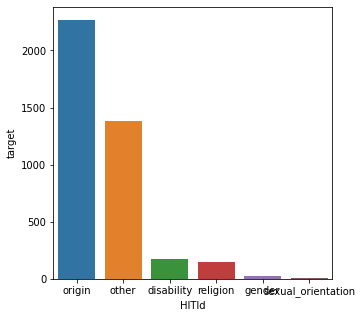

In [9]:
#### Class distribution 
cum = df_fr['target'].value_counts().to_frame()
cum['HITId'] = cum.index
cumfig, ax = plt.subplots(figsize=(5,5))
sn.barplot(data=cum,x='HITId',y='target',ax=ax)

#### 4.1.2 Assest dataset

In [10]:
df_fr2.head()

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir david carr du troisième jour pour le faire. ;ré"
1,0,"Est contrarié qu'il ne puisse pas mettre à jour son facebook en le télémaignant ... et peut-être pleurer en conséquence, l'école aujourd'hui aussi. blabla!"
2,0,J'ai plongé plusieurs fois pour la balle. A réussi à économiser 50% le reste sort de limites
3,0,Tout mon corps a des démangeaisons et comme si c'était en feu
4,0,"Non, il ne se comporte pas du tout. je suis en colère. pourquoi suis-je ici? Parce que je ne peux pas vous voir partout."


In [11]:
print('Size of the dataset:')
len(df_fr2)

Size of the dataset:


1526724

In [12]:
#test if the data contains null values
print('Nan value',df_fr2.isnull().sum())

Nan value label    0
text     0
dtype: int64


### 4.2 Arabic dataset

#### 4.2.1 Main dataset

In [13]:
df_ar.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون,hateful_normal,indirect,shock,gender,individual
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي… @url,offensive,indirect,anger_confusion_sadness_indifference_disgust,other,other
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون ....... @url,offensive,indirect,indifference,other,individual
3,4,@user @user انا اوافقك بخصوص السوريين و العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو… @url,normal,direct,indifference,origin,other
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير الذي يستهزأ بها الناس,normal,indirect,indifference,origin,other


In [14]:
df_ar.describe()

,HITId
count,3353.000000
mean,1677.000000
std,968.072053
min,1.000000
25%,839.000000
50%,1677.000000
75%,2515.000000
max,3353.000000


In [15]:
print('Size of the dataset:')
len(df_ar)

Size of the dataset:


3353

In [16]:
#test if the data contains null values
print('Nan value',df_ar.isnull().sum())

Nan value HITId                  0
tweet                  0
sentiment              0
directness             0
annotator_sentiment    0
target                 0
group                  0
dtype: int64


<AxesSubplot:xlabel='HITId', ylabel='target'>

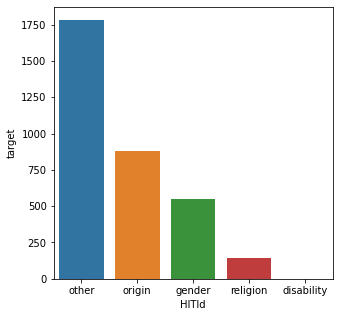

In [17]:
#### Class distribution 
cum = df_ar['target'].value_counts().to_frame()
cum['HITId'] = cum.index
cumfig, ax = plt.subplots(figsize=(5,5))
sn.barplot(data=cum,x='HITId',y='target',ax=ax)

#### 4.2.2 Assest dataset

In [18]:
df_ar2.head()

,ID,Feed,Sentiment
0,1,اربد فيها جامعات اكثر من عمان ... وفيها قد عمان ونص لعيبه المنتخب منها ... و 80 % من مطربين الاردن منها,Positive
1,2,الحلو انكم بتحكوا على اساس انو الاردن ما فيه فساد سرقات,Negative
2,3,كله رائع بجد ربنا يكرمك,Positive
3,4,لسانك قذر يا قمامه,Negative
4,5,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش واحيانا اهرب مخدرات و اجيد التسليك احب ان انكب نفسي وعلاقتي بالمنزل متوتره جد,Negative


In [19]:
print('Size of the dataset:')
len(df_ar2)

Size of the dataset:


1800

In [20]:
#test if the data contains null values
print('Nan value',df_ar2.isnull().sum())

Nan value ID           0
Feed         0
Sentiment    0
dtype: int64


## 5. Preprocessing on the datasets

### 5.1 French Dataset

#### 5.1.1 Hateful tweets

In [21]:
# negative tweets contained
# we put target = 0 negative
neg = df_fr.loc[df_fr['target']!='normal','target'] = 0
neg = df_fr

#### 5.1.1 No hateful tweets

In [22]:
#positive tweets contained in the assest dataset
pos = df_fr2.loc[df_fr2['label']==1]
#since we have a several amount of data, we take a part of it
pos= pos.rename(columns={'label':'target','text':'tweet'})
n = len(pos)
pos= pos[0:int(n/100)]

#### 5.1.3 Merging 

In [23]:
# merging the two dataframes
data_fr = pd.concat([neg,pos], ignore_index=True, sort=False)
data_fr.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1.0,rt @user personnage ainsi q tte la clique gauchiste deguise 1 macronistes !!ont ttes ls qualites requises qui ont etaient inculq,abusive,direct,shock,0,other
1,2.0,@user @user @user bah oui t'as raison l'autre c'est un mongol.,offensive,indirect,shock,0,individual
2,3.0,moi j'ai personne à qui m'adresser pour réclamer. le voisin c'est un attardé puant et bruyant dans les administrat… @url,hateful,direct,anger_confusion_sadness_fear_disgust,0,women
3,4.0,@user @user c...est vrai que les anchois sont aller sur la lune et invente de million de technologie !,normal,indirect,indifference,0,other
4,5.0,eh les renois faut se réveiller la @url,normal,direct,sadness,0,african_descent


In [24]:
# fixing nan values
data_fr.loc[data_fr['sentiment'].isnull().values==True,'sentiment'] = 'normal'
data_fr.loc[data_fr['directness'].isnull().values==True,'directness'] = 'direct'
data_fr.loc[data_fr['group'].isnull().values==True,'group'] = 'nothing'
data_fr.loc[data_fr['annotator_sentiment'].isnull().values==True,'annotator_sentiment'] = 'indifference'
data_fr = data_fr.sample(frac = 1)
data_fr.reindex().head()
data_fr = data_fr.drop(columns={'HITId'})
data_fr.head()

,tweet,sentiment,directness,annotator_sentiment,target,group
8521,impressionnant!! Peux pas attendre de voir ça!!,normal,direct,indifference,1,nothing
7439,Fait réserver des vols pour retourner à la maison,normal,direct,indifference,1,nothing
8237,"Brrrr .... j'ai tellement froid, mais je l'aime",normal,direct,indifference,1,nothing
8047,"Www.youtube.com/titomi15..Vérifiez les vidéos, les commentaires et les présentations! & Amp; Suivez moi, encouragez x",normal,direct,indifference,1,nothing
3461,@user @user j’ai rien contre lui j’rigolais mongol va,offensive_disrespectful,direct,sadness,0,individual


#### 5.1.4 Distribution of data 

<AxesSubplot:xlabel='tweet', ylabel='target'>

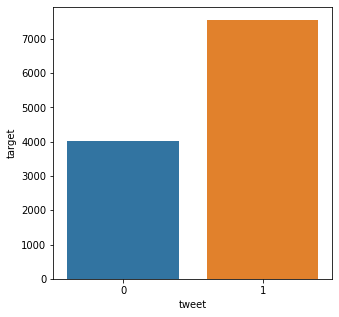

In [25]:
# distribution of classes: 0,1
cum = data_fr['target'].value_counts().to_frame()
cum['tweet'] = cum.index
cumfig, ax = plt.subplots(figsize=(5,5))
sn.barplot(data=cum,x='tweet',y='target',ax=ax)

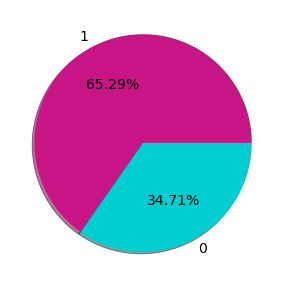

In [26]:
plt.figure(figsize=(5,5))
plt.pie(data_fr["target"].value_counts(),labels=data_fr["target"].value_counts().index,autopct=lambda p:f'{p:.2f}%',
        shadow=True,colors=['mediumvioletred','darkturquoise'],labeldistance = 1.1,textprops={'fontsize': 14})

plt.savefig("distribution des données dans les différentes classes.png")
plt.show()

#### 5.1.5 Encoding columns

In [27]:
#encoding labels
le = preprocessing.LabelEncoder()
data_fr.sentiment = le.fit_transform(data_fr.sentiment)
data_fr.directness = le.fit_transform(data_fr.directness)
data_fr.annotator_sentiment = le.fit_transform(data_fr.annotator_sentiment)
data_fr.group = le.fit_transform(data_fr.group)
data_fr = data_fr.sample(frac = 1)
data_fr

,tweet,sentiment,directness,annotator_sentiment,target,group
5740,bonne nuit!,60,0,88,1,12
9265,"Je déteste également travailler, mais nous devons le faire pour avoir l'air bien! Il suffit de garder à l'esprit qu'il en vaut la peine !!!",60,0,88,1,12
11200,"Super ici, j'espère que vous êtes le même et que les chansons sont incroyables, ce que je pense que ça va arriver",60,0,88,1,12
9556,"Oui, j'adore les Caramellow! Seulement deux jours de plus jusqu'à la pause de Pâques ... je suis tellement excité, le stress de l'école laissé derrière!",60,0,88,1,12
10161,Cor my new custom rig juste rire face à gauche 4 morts et jeux similaires,60,0,88,1,12
...,...,...,...,...,...,...
7704,"Oui, et ça ne tardera pas à jouer de lapin de Pâques aussi! C'est tellement amusant. As-tu été bien?",60,0,88,1,12
2810,manœuvre gauchiste habituelle : @user essaye de détourner l'attention portée sur #nickconrad en utilisant… @url,56,0,100,0,10
11422,"J'aime penser à cela plus comme une décharge de masse. Mais oui, je pense ne plus suivre, c'est le terme technique",60,0,88,1,12
1278,des meufs : « mon style de gars c’est les renois » un mois après elle sorte avec des jérémy #cesoirtribunal,57,0,89,0,0


### 5.2 Arabic dataset

#### 5.2.1 Hateful tweets

In [28]:
neg = df_ar.loc[df_ar['target']!='normal','target'] = 0
neg = df_ar
neg.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون,hateful_normal,indirect,shock,0,individual
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي… @url,offensive,indirect,anger_confusion_sadness_indifference_disgust,0,other
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون ....... @url,offensive,indirect,indifference,0,individual
3,4,@user @user انا اوافقك بخصوص السوريين و العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو… @url,normal,direct,indifference,0,other
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير الذي يستهزأ بها الناس,normal,indirect,indifference,0,other


#### 5.2.2 No Hateful tweets

In [29]:
#positive tweets contained in the assest dataset
df_ar2.loc[df_ar2['Sentiment']=='Positive']
df_ar2.loc[df_ar2['Sentiment']=='Positive','Sentiment'] = 1
pos = df_ar2.loc[df_ar2["Sentiment"]==1]
pos= pos.rename(columns={'Sentiment':'target','Feed':'tweet'})
pos = pos.drop(columns={'ID'})

#### 5.2.3 Merging

In [30]:
# merging the two dataframes
data_ar = pd.concat([neg[0:int(len(pos)/1.5)],pos], ignore_index=True, sort=False)
data_ar.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1.0,صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون,hateful_normal,indirect,shock,0,individual
1,2.0,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي… @url,offensive,indirect,anger_confusion_sadness_indifference_disgust,0,other
2,3.0,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون ....... @url,offensive,indirect,indifference,0,individual
3,4.0,@user @user انا اوافقك بخصوص السوريين و العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو… @url,normal,direct,indifference,0,other
4,5.0,هذه السعودية التي شعبها شعب الخيم و بول البعير الذي يستهزأ بها الناس,normal,indirect,indifference,0,other


In [31]:
data_ar.loc[data_ar['sentiment'].isnull().values==True,'sentiment'] = 'normal'
data_ar.loc[data_ar['directness'].isnull().values==True,'directness'] = 'direct'
data_ar.loc[data_ar['group'].isnull().values==True,'group'] = 'nothing'
data_ar.loc[data_ar['annotator_sentiment'].isnull().values==True,'annotator_sentiment'] = 'indifference'
data_ar = data_ar.sample(frac = 1)
data_ar = data_ar.sample(frac = 1)
data_ar.drop(columns='HITId')

,tweet,sentiment,directness,annotator_sentiment,target,group
1029,ربك دايما جنبك لو نديته هتلاقيه,normal,direct,indifference,1,nothing
33,@user @user كلهم خنازير المجوس,abusive_hateful,indirect,anger_disgust,0,other
258,@user @user @user @user عايزه تخصى العالم كله عشان متجوزتيش يا بايره,hateful,direct,disgust,0,individual
1475,يارب دعوناك فستجب لنا وحقق لنا ماهو اصلح وافضل لنا,normal,direct,indifference,1,nothing
856,اللهم ثبتنا بالقول الثابت في الحياه الدنيا وفي الاخره,normal,direct,indifference,1,nothing
...,...,...,...,...,...,...
336,@user @user @user فعلاً من ديت لي ديت والله بايره انا دي ي مونياه,abusive_offensive,indirect,indifference_disgust,0,women
250,حوادث التحرش تحدث كثيراً في السودان وغيره، مسارها الطبيعي أن يتجه الطرفان إلى القانون وأحياناً تأخذ الفتاة حقها في… @url,normal,indirect,indifference,0,women
570,ما انصح بزيارة اوربا بشكل عام بشهر فبراير بسبب الاجواء الشتوية القارصة..لاسيما وانت تتلكم عن شهر عسل,normal,indirect,indifference,0,other
705,الدعوه مش بالكلام بس ممكن نكون دعاه باخلاقنا اسلوبنا تعاملنا,normal,direct,indifference,1,nothing


#### 5.2.4 Data distribution before resampling

<AxesSubplot:xlabel='tweet', ylabel='target'>

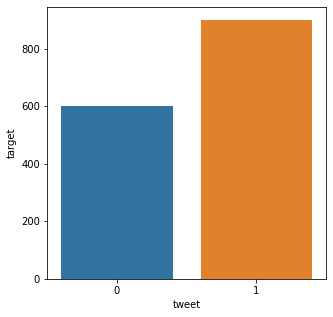

In [32]:
# distribution of classes: 0,1
cum = data_ar['target'].value_counts().to_frame()
cum['tweet'] = cum.index
cumfig, ax = plt.subplots(figsize=(5,5))
sn.barplot(data=cum,x='tweet',y='target',ax=ax)

#### 5.2.5 Resampling

In [33]:
def resample(df):
    setnew = df
    lab0,lab1 = setnew[setnew['target'] == 0], setnew[setnew['target'] == 1]
    c0, c1 = setnew['target'].value_counts()
  
    lab0_sampled = lab0.sample(c0, replace=True) 
    lab1_sampled = lab1.sample(3*c1, replace=True)

    setnew_resampled = pd.concat([lab0_sampled,lab1_sampled], axis=0)
    setnew_resampled = setnew_resampled.sample(frac = 1)
    return setnew_resampled

In [34]:
data_ar = resample(data_ar)
data_ar = data_ar.drop(columns={'HITId'})
data_ar.head()

,tweet,sentiment,directness,annotator_sentiment,target,group
335,كل دول العالم فيها ظاهرة التحرش بالذات مع البنات سواء بنص اليوم او بنص الليل متستره او شبه عاريه وبنسب كثيره بعد بس… @url,abusive_normal,direct,sadness,0,women
333,#غرد_مثل_موقع_القوات حسومات على بول البعير,normal,indirect,indifference_disgust,0,other
977,تحيه محبه وسلام,normal,direct,indifference,1,nothing
701,الخشوع احساس جميل جد امام الله القلب يحب الدمع صافي متعه بعد الصلاه راحه فائقه اتمنى لكل المسلمين هذا الخشوع,normal,direct,indifference,1,nothing
167,@user @user @user @user أني عراقي تاج على راسك يابدوي يا شارب بول البعير.,offensive,direct,anger_disgust,0,individual


#### 5.2.6 Data distribution after resampling

<AxesSubplot:xlabel='tweet', ylabel='target'>

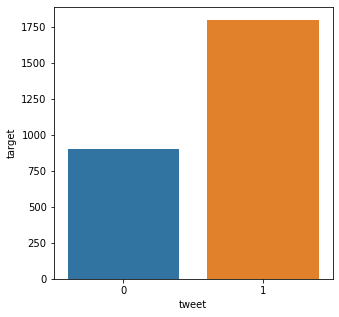

In [35]:
# distribution of classes: 0,1
cum = data_ar['target'].value_counts().to_frame()
cum['tweet'] = cum.index
cumfig, ax = plt.subplots(figsize=(5,5))
sn.barplot(data=cum,x='tweet',y='target',ax=ax)

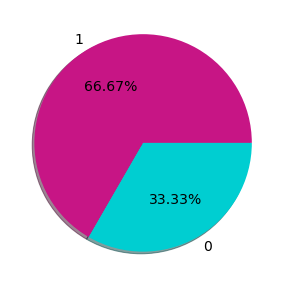

In [36]:
plt.figure(figsize=(5,5))
plt.pie(data_ar["target"].value_counts(),labels=data_ar["target"].value_counts().index,autopct=lambda p:f'{p:.2f}%',
        shadow=True,colors=['mediumvioletred','darkturquoise'],labeldistance = 1.1,textprops={'fontsize': 14})

plt.savefig(" ara distribution des données dans les différentes classes.png")
plt.show()

#### 5.2.7 Encoding columns


In [37]:
data_ar.sentiment = le.fit_transform(data_ar.sentiment)
data_ar.directness = le.fit_transform(data_ar.directness)
data_ar.annotator_sentiment = le.fit_transform(data_ar.annotator_sentiment)
data_ar.group = le.fit_transform(data_ar.group)
data_ar = data_ar.sample(frac = 1)
data_ar.head()

,tweet,sentiment,directness,annotator_sentiment,target,group
993,جميله المعاني المجرده التي تنزوي عند التطبيق,17,0,15,1,8
653,اكيد جزاك الله خيرا,17,0,15,1,8
582,حتي التحرش محرومة منه,18,1,11,0,5
503,@user @user بول البعير ادفع الجزية يا خائن العرب و المسلمين @user,15,0,13,0,5
729,الله الله عليك يا استاذ عمر بارك الله لك بارك عليك جزاك الله عنا خيرا كثير,17,0,15,1,8


## 6. Preprocessing/Cleaning on tweets

### 6.1 Help functions

In [38]:
def hash_fix(h):
    h1 = re.sub(r'[0-9]+', '', h)
    h2 = re.sub(r'#', '', h1)
    h3 = segment(str(h2))
    h4 = ' '.join(map(str, h3)) 
    return h4

In [39]:
tok_ar = tk.WordTokenizer()
tok_ar.train('/kaggle/input/twitter/ar_dataset.csv')
def prepro_ar(tweet):
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    
    tweet = tweet.replace('user', '')
    tweet = tweet.replace('@user', '')
    tweet = re.sub( r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'',tweet)

    tweet = tweet.replace('url', '')
    tweet = re.sub(r"\p{P}", lambda m: "", tweet)
    tweet = re.sub(arabic_diacritics, '', str(tweet))
    tweet = re.sub(r'(.)\1+', "", tweet) 
    tweet = ar.strip_tashkeel(tweet)
    tweet = ar.strip_tatweel(tweet)
    tweet = tweet.replace("@", " ")
    tweet = tweet.replace("_", " ")
    tweet = re.sub("ى", "ي", tweet)
    tweet = re.sub("ؤ", "ء", tweet)
    tweet = re.sub("ئ", "ء", tweet)
    tweet = re.sub("ة", "ه", tweet)
    tweet = re.sub("گ", "ك", tweet)
    tweet = tweet.replace("آ", "ا")
    tweet = tweet.replace("إ", "ا")
    tweet = tweet.replace("أ", "ا")
    tweet = tweet.replace("ؤ", "و")
    tweet = tweet.replace("ئ", "ي")
    tweet = nltk.tokenize.word_tokenize(tweet)
    tweet = [ISRIStemmer().suf32(w) for w in tweet]
    for i in range(len(tweet)):
        if tweet[i] == 'اه':
            tweet[i] = 'الله'
    return tweet

Training WordTokenizer ...


In [40]:
contractions_fr = {
        'administration':'admin',
        'avec':'ac',
        'beaucoup':'bp',
        'c’est-à-dire':'cad',
        'cependant':'cpd',
        'chose':'ch',
        'conclusion':'ccl',
        'confer ':'cf',
        'court terme':'ct',
        'dans':'ds',
        'dedans':'dd',
        'définition':'déf',
        'et cetera':'etc',
        'être':'ê',
        'exemple':'ex',
        'extérieur':'ext',
        'font':'ft',
        'général':'gal',
        'gouvernement':'gouv',
        'grand':'gd',
        'groupe':'gp',
        'identique':'idel',
        'introduction':'intro',
        'jour':'jr',
        'long terme':'lt',
        'lorsque':'lsq',
        'mais':'ms',
        'même':'^m',
        'moyen terme':'mt',
        'nombre':'nb',
        'nombreux':'nbx',
        'nombre':'nb',
        'nombreux':'nbx',
        'observation':'obs',
        'ordre du jour':'oj',
        'page':'p',
        'parce que':'pcq',
        'pendant':'pdt',
        'personne':'pers',
        'point':'pt',
        'peut-être':'pê',
        'pour':'pr',
        'pourtant':'prtt',
        'quand':'qd',
        'quantité':'qté',
        'que':'q',
        'quelqu’un':'qqn',
        'quelque chose':'qqch',
        'quelque':'qq',
        'quelquefois':'qqf',
        'question':'quest',
        'rendez-vous':'rdv',
        'responsabilité':'respité',
        'seulement':'slt',
        'solution':'sol',
        'sont':'st',
        'sous':'ss',
        'souvent':'svt',
        'temps':'tps',
        'toujours':'tjrs',
        'tous':'ts',
        'tout':'tt',
        'toute':'tte',
        'toutes':'ttes',
        'vous':'vs',
        'le':'l\'',
        'me':'m\'',
        'de':'d\'',
        'te':'t\'',
        'se':'s\'',
        'ce':'c\'',
        'ne':'n\'',
        'que':'qu\'',
        'jusque':'jusqu\'',
        'lorsque':'lorsqu\'',
        'puisque':'puisqu\'',
        'quelque':'quelqu\'',
        'quoique':'quoiqu\'',
        'parce que':'parce qu\'',
        'tel que':'tel qu\'',
        'telle que':'telle qu\'',       
        'faculte':'fac',
        'bien':'bin',    
        'attend':'att',
        'je': 'j\'',
        'rire':'ptdr',
        'rire':'lol',
        'rire':'lmfao',
        'putin':'ptn',
}

In [41]:
french_stopwords = nltk.corpus.stopwords.words('french')
lemmatizer = FrenchLefffLemmatizer()
spell = SpellChecker(language='fr')

In [42]:
def prepro_fr(tweet):
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # normalize unicode characters
    tweet = normalize('NFD', tweet).encode('ascii','ignore')
    tweet = tweet.decode('UTF-8')
    #demojize
    tweet = emoji.demojize(tweet)
    if "#" in tweet:
        tweet = hash_fix(tweet)
    tweet = tweet.replace('user', '')
    tweet = tweet.replace('@user', '')
    tweet = tweet.replace('url', '')
    tweet = re.sub( r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'',tweet)
    # convert to lower case
    tweet = tweet.lower()
    tweet = tweet.replace('\'', '\' ') 
    # remove punctuation
    tweet = re.sub(r"\p{P}", lambda m: "-" if m.group(0) == "-" else "", tweet)
    # tokenization
    tweet = nltk.tokenize.word_tokenize(tweet)
    #contractions
    tweet = [list(contractions_fr.keys())[list(contractions_fr.values()).index(word)] if word in contractions_fr.values() else word for word in tweet]
    
    # stop words
    tweet = [w for w in tweet if w not in french_stopwords]
    sc = 'j[a-z]*'
    v = '[^aeyouisch]*'
    for w in tweet:
        x = re.findall(sc,w)
        xx = re.findall(v,w)
        if len(x)!=0:
            w = x[0].replace('j', 'je ')
            if len(x)>=3:
                w = w.replace(xx[0], '')
    # remove non-printable chars form each token
    tweet = [re_print.sub('', w) for w in tweet]
    # lemmatization
    tweet = [lemmatizer.lemmatize(w) for w in tweet]
    return tweet

### 6.2 Arabic

In [43]:
data_ar.tweet = data_ar.tweet.apply(lambda t: prepro_ar(t))

In [44]:
data_ar.head()

,tweet,sentiment,directness,annotator_sentiment,target,group
993,"[جميله, المعا, المجرده, التي, تنزوي, عند, التطبيق]",17,0,15,1,8
653,"[اكيد, جزاك, الله, خيرا]",17,0,15,1,8
582,"[حتي, التحرش, محرومه, منه]",18,1,11,0,5
503,"[بول, البعيرادفع, الجزيه, يا, خاءن, العرب, و, المسلم]",15,0,13,0,5
729,"[الله, الله, عليك, يا, استاذ, عمر, بارك, الله, لك, بارك, عليك, جزاك, الله, عنا, خيرا, كثير]",17,0,15,1,8


### 6.3 French

In [45]:
data_fr.tweet = data_fr.tweet.apply(lambda t: prepro_fr(t))

In [46]:
data_fr.head()

,tweet,sentiment,directness,annotator_sentiment,target,group
5740,"[bonne, nuit]",60,0,88,1,12
9265,"[deteste, egalement, travailler, devon, faire, avoir, air, bien, suffit, garder, a, esprit, vaut, peine]",60,0,88,1,12
11200,"[super, ici, espere, etes, meme, chanson, incroyable, pense, ca, va, arriver]",60,0,88,1,12
9556,"[oui, adore, caramellow, seulement, deux, jour, plus, jusqu, a, pause, paques, tellement, excite, stress, ecole, laisse, derriere]",60,0,88,1,12
10161,"[cor, my, new, custom, rig, juste, rire, face, a, gauche, 4, mort, jeu, similaires]",60,0,88,1,12


## 7. Splitting Data

## 7.1 Arabic

In [47]:
labels_ar = data_ar.target.values
data_ar = data_ar.drop(columns={'target'})

In [48]:
X_train_ar,X_test_ar, y_train_ar,y_test_ar = train_test_split(data_ar,
                                                              labels_ar,
                                                              test_size=0.1)


### 7.2 French

In [49]:
labels_fr = data_fr.target.values
data_fr = data_fr.drop(columns={'target'})

In [50]:
X_train_fr,X_test_fr, y_train_fr,y_test_fr = train_test_split(data_fr,
                                                              labels_fr,
                                                              test_size=0.1)

## 8. Word Embedding

In [51]:
embed_dim = 300 

### Help functions

In [52]:
emd_vect =  100
def embedding_mat(file, word_index):
    embedding_dict = {}
    for line in file:
        values=line.split()
        word=values[0]
        if word in word_index.keys():
            vector = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vector

    num_words=len(word_index)+1
    embedding_matrix=np.zeros((num_words, emd_vect))
    for word,i in tqdm(word_index.items()):
        vect=embedding_dict.get(word)
        if vect is not None:
            embedding_matrix[i]  = vect[:emd_vect]
    return embedding_matrix

### 8.1 Arabic

In [53]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz

--2022-02-22 08:15:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  33.9MB/s    in 34s     

2022-02-22 08:15:39 (36.2 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [54]:
!gunzip cc.ar.300.vec.gz

In [55]:
f_ar = open('cc.ar.300.vec', encoding='utf-8')

In [56]:
X_train_ar1 = list(X_train_ar.tweet.values)
X_test_ar1 = list(X_test_ar.tweet.values)

tok_ar = Tokenizer()
tok_ar.fit_on_texts(data_ar.tweet.values)
word_index_ar = tok_ar.word_index

#text to integer sequence
X_train_ar1 = tok_ar.texts_to_sequences(X_train_ar1)
X_test_ar1 = tok_ar.texts_to_sequences(X_test_ar1)

In [57]:
tweets_length_ar= [len(X_train_ar1[i]) for i in range(len(X_train_ar1))]
max_seq_len_ar = max(tweets_length_ar)
print(max_seq_len_ar)

32


In [58]:
#padding
X_train_ar1 = pad_sequences(X_train_ar1, padding='post', maxlen=max_seq_len_ar)
X_test_ar1 = pad_sequences(X_test_ar1, padding='post', maxlen=max_seq_len_ar)

In [59]:
X_train_ar2 = X_train_ar[['sentiment', 'directness', 'annotator_sentiment', 'group']].values
X_test_ar2 = X_test_ar[['sentiment', 'directness', 'annotator_sentiment', 'group']].values

In [60]:
embedding_matrix_ar = embedding_mat(f_ar, tok_ar.word_index)

  0%|          | 0/5258 [00:00<?, ?it/s]

In [87]:
embedding_matrix_ar

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.118     ,  0.0557    , -0.1025    , ..., -0.1733    ,
         0.17219999, -0.0378    ],
       [-0.0685    , -0.0172    , -0.0627    , ..., -0.003     ,
        -0.0455    , -0.0132    ],
       ...,
       [-0.2146    , -0.138     , -0.162     , ..., -0.0513    ,
        -0.1454    ,  0.0965    ],
       [-0.0766    , -0.0803    , -0.0575    , ..., -0.0912    ,
        -0.0048    ,  0.2097    ],
       [ 0.007     , -0.0027    , -0.0526    , ...,  0.0451    ,
        -0.018     , -0.0201    ]])

### 8.2 French

In [61]:
#Loading embedding  model!
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz

--2022-02-22 08:17:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1287757366 (1.2G) [binary/octet-stream]
Saving to: ‘cc.fr.300.vec.gz’

cc.fr.300.vec.gz    100%[===================>]   1.20G  36.5MB/s    in 32s     

2022-02-22 08:17:49 (38.4 MB/s) - ‘cc.fr.300.vec.gz’ saved [1287757366/1287757366]



In [62]:
!gunzip cc.fr.300.vec.gz

In [63]:
f_fr = open('cc.fr.300.vec', encoding='utf-8')

In [64]:
X_train_fr1 = list(X_train_fr.tweet.values)
X_test_fr1 = list(X_test_fr.tweet.values)

tok_fr = Tokenizer()
tok_fr.fit_on_texts(data_fr.tweet.values)
#text to integer sequence
X_train_fr1 = tok_fr.texts_to_sequences(X_train_fr1)
X_test_fr1 = tok_fr.texts_to_sequences(X_test_fr1)

In [65]:
#counting the length of the tweet and taking the max
tweets_length_fr= [len(X_train_fr1[i]) for i in range(len(X_train_fr1))]
max_seq_len_fr = max(tweets_length_fr)
print(max_seq_len_fr)

45


In [66]:
#padding
X_train_fr1 = pad_sequences(X_train_fr1, maxlen=max_seq_len_fr)
X_test_fr1 = pad_sequences(X_test_fr1, maxlen=max_seq_len_fr)

In [67]:
X_train_fr2 = X_train_fr[['sentiment', 'directness', 'annotator_sentiment', 'group']].values
X_test_fr2 = X_test_fr[['sentiment', 'directness', 'annotator_sentiment', 'group']].values

In [68]:
embedding_matrix_fr = embedding_mat(f_fr, tok_fr.word_index)

  0%|          | 0/17128 [00:00<?, ?it/s]

In [88]:
embedding_matrix_fr

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0092    ,  0.0073    , -0.2033    , ...,  0.2112    ,
        -0.0495    ,  0.30689999],
       [ 0.0314    ,  0.0079    , -0.0479    , ..., -0.1899    ,
        -0.0904    ,  0.1381    ],
       ...,
       [-0.072     ,  0.001     , -0.0142    , ..., -0.0603    ,
         0.0343    , -0.0128    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0151    ,  0.1251    ,  0.0714    , ...,  0.0114    ,
         0.0629    , -0.0035    ]])

## 9. Model

### 9.1 Building model

In [69]:
input_fr_1 = Input(shape=(max_seq_len_fr,))
input_ar_1 = Input(shape=(max_seq_len_ar,))
input_2 = Input(shape=(4,))

In [70]:
nb_words_fr = len(tok_fr.word_index)+1
embedding_layer_fr = Embedding(
                            nb_words_fr, 
                            100,  
                            weights=[embedding_matrix_fr],
                            trainable=False,
                    )

In [71]:
nb_words_ar = len(tok_ar.word_index)+1
embedding_layer_ar = Embedding(
                            nb_words_ar, 
                            100,  
                            weights=[embedding_matrix_ar],
                            trainable=False,
                    )

In [144]:
def NN(lang,input_1,input_2):
    if lang=='AR':  
        embedding_layer = embedding_layer_ar(input_1)
    else:
        embedding_layer = embedding_layer_fr(input_1)

    lstm = LSTM(128)(embedding_layer)
    dense_layer_1 = Dense(10, activation='relu')(input_2)
    dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
    concat_layer = Concatenate()([lstm, dense_layer_2])
    dense_layer_3 = Dense(10, activation='relu')(concat_layer)
    
    output = Dense(1, activation='sigmoid')(dense_layer_3)
    
    model = Model(inputs=[input_1, input_2], outputs=output)
    
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model

In [145]:
embedding_layer_ar.get_weights()

[array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.118 ,  0.0557, -0.1025, ..., -0.1733,  0.1722, -0.0378],
        [-0.0685, -0.0172, -0.0627, ..., -0.003 , -0.0455, -0.0132],
        ...,
        [-0.2146, -0.138 , -0.162 , ..., -0.0513, -0.1454,  0.0965],
        [-0.0766, -0.0803, -0.0575, ..., -0.0912, -0.0048,  0.2097],
        [ 0.007 , -0.0027, -0.0526, ...,  0.0451, -0.018 , -0.0201]],
       dtype=float32)]

In [146]:
embedding_layer_fr.get_weights()[0]

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.0092,  0.0073, -0.2033, ...,  0.2112, -0.0495,  0.3069],
       [ 0.0314,  0.0079, -0.0479, ..., -0.1899, -0.0904,  0.1381],
       ...,
       [-0.072 ,  0.001 , -0.0142, ..., -0.0603,  0.0343, -0.0128],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-0.0151,  0.1251,  0.0714, ...,  0.0114,  0.0629, -0.0035]],
      dtype=float32)

### 9.2 Training Model

In [147]:
#hyperparameters
num_epochs = 10
batch_size = 64
early = callbacks.EarlyStopping(monitor='val_loss',
                                min_delta=0, 
                                patience=3,
                                verbose=1, 
                                mode='auto')

### 9.2.1 French

In [148]:
model_fr = NN('FR',input_fr_1,input_2)
model_fr.compile(optimizer = 'sgd',
                 loss = 'binary_crossentropy', 
                 metrics = ['accuracy'])

print('French:')
Xfr = [X_train_fr1,X_train_fr2]
history_fr = model_fr.fit(Xfr,
                          y_train_fr.astype('float32'),
                          batch_size=batch_size,
                          epochs=num_epochs,
                          validation_split=0.1,
                          callbacks = [early],
                          verbose=1)

French:
Epoch 1/10
147/147 [==============================] - 13s 76ms/step - loss: 0.6127 - accuracy: 0.7343 - val_loss: 0.4923 - val_accuracy: 0.7752
Epoch 2/10
147/147 [==============================] - 10s 65ms/step - loss: 0.4440 - accuracy: 0.8183 - val_loss: 0.4658 - val_accuracy: 0.7925
Epoch 3/10
147/147 [==============================] - 10s 66ms/step - loss: 0.3980 - accuracy: 0.8456 - val_loss: 0.3037 - val_accuracy: 0.8886
Epoch 4/10
147/147 [==============================] - 10s 70ms/step - loss: 0.3958 - accuracy: 0.8478 - val_loss: 0.3897 - val_accuracy: 0.8463
Epoch 5/10
147/147 [==============================] - 10s 65ms/step - loss: 0.3775 - accuracy: 0.8594 - val_loss: 0.3910 - val_accuracy: 0.8482
Epoch 6/10
147/147 [==============================] - 10s 66ms/step - loss: 0.3738 - accuracy: 0.8662 - val_loss: 0.3848 - val_accuracy: 0.8453
Epoch 00006: early stopping


### 9.2.2 Arabic

In [151]:
model_ar = NN('AR',input_ar_1,input_2)
model_ar.compile(optimizer = 'sgd',
                 loss = 'binary_crossentropy', 
                 metrics = ['accuracy'])

print('Arabic:')
Xar = [np.asarray(X_train_ar1), np.asarray(X_train_ar2)]
history_ar = model_ar.fit(Xar,
                          y_train_ar.astype(np.float32),
                          batch_size=batch_size,
                          epochs=num_epochs,
                          validation_split=0.1,
                          callbacks = [early],
                          verbose=1)

Arabic:
Epoch 1/10
35/35 [==============================] - 5s 65ms/step - loss: 0.6338 - accuracy: 0.6621 - val_loss: 0.5834 - val_accuracy: 0.7202
Epoch 2/10
35/35 [==============================] - 2s 48ms/step - loss: 0.5753 - accuracy: 0.7275 - val_loss: 0.5591 - val_accuracy: 0.7325
Epoch 3/10
35/35 [==============================] - 2s 51ms/step - loss: 0.5456 - accuracy: 0.7471 - val_loss: 0.5194 - val_accuracy: 0.7531
Epoch 4/10
35/35 [==============================] - 2s 48ms/step - loss: 0.5161 - accuracy: 0.7586 - val_loss: 0.5160 - val_accuracy: 0.7613
Epoch 5/10
35/35 [==============================] - 2s 48ms/step - loss: 0.4994 - accuracy: 0.7641 - val_loss: 0.4942 - val_accuracy: 0.7942
Epoch 6/10
35/35 [==============================] - 2s 48ms/step - loss: 0.4712 - accuracy: 0.7819 - val_loss: 0.4575 - val_accuracy: 0.7942
Epoch 7/10
35/35 [==============================] - 2s 48ms/step - loss: 0.4553 - accuracy: 0.7920 - val_loss: 0.4510 - val_accuracy: 0.7901
Epoch

### 9.3 Evaluating & Testing model

#### 9.3.1 Help functions

In [137]:
def plot_acc_loss(history):
    """
    Plot accuracy and loss of a model
    @params:
            - history: history of the model
    @return:
            plots
    """
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    l = list(history.history.keys())
    print(l)
    # accuracy plot
    ax[0].plot(history.history[l[1]])
    ax[0].plot(history.history[l[3]])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='upper left')
    # loss plot
    ax[1].plot(history.history[l[0]])
    ax[1].plot(history.history[l[2]])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper left')

In [152]:
def predicted_label(model,x):
    pred = model.predict(x)
    lab_pred = []
    for i in range(len(pred)):
        if pred[i][0]>=0.5:
            lab_pred.append(1)
        else:
            lab_pred.append(0)
    return lab_pred

In [153]:
def plot_cm(model,x,y):
    pred = model.predict(x)
    y_pred = predicted_label(model,x)
    cm = confusion_matrix(list(y),y_pred)  
    sn.heatmap(cm, annot=True)

#### 9.3.2 Arabic

['loss', 'accuracy', 'val_loss', 'val_accuracy']


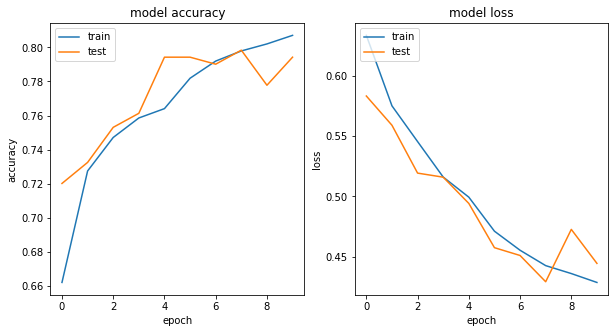

In [154]:
plot_acc_loss(history_ar)

Confusion Matrix for arabic dataset


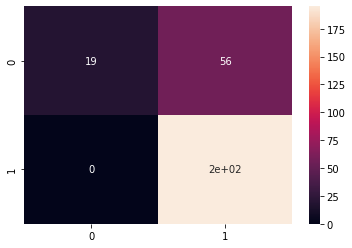

In [155]:
print("Confusion Matrix for arabic dataset")
Xtestar = [np.asarray(X_test_ar1), np.asarray(X_test_ar2)]
plot_cm(model_ar,Xtestar,y_test_ar)

In [156]:
test_loss_ar, test_acc_ar = model_ar.evaluate(Xtestar,y_test_ar.astype(np.float32))
print('Test accuracy:', test_acc_ar)

9/9 [==============================] - 0s 12ms/step - loss: 0.4288 - accuracy: 0.7926
Test accuracy: 0.7925925850868225


In [157]:
pred_ar =predicted_label(model_ar,Xtestar)
# accuracy: (tp + tn) / (p + n)
accuracy_ar = accuracy_score(list(y_test_ar), pred_ar)
print('Accuracy: %f' % accuracy_ar)
# precision tp / (tp + fp)
precision_ar = precision_score(list(y_test_ar), pred_ar)
print('Precision: %f' % precision_ar)
# recall: tp / (tp + fn)
recall_ar = recall_score(list(y_test_ar), pred_ar)
print('Recall: %f' % recall_ar)
# f1: 2 tp / (2 tp + fp + fn)
f1_ar = f1_score(list(y_test_ar), pred_ar)
print('F1 score: %f' % f1_ar)

Accuracy: 0.792593
Precision: 0.776892
Recall: 1.000000
F1 score: 0.874439


#### 9.3.4 French

['loss', 'accuracy', 'val_loss', 'val_accuracy']


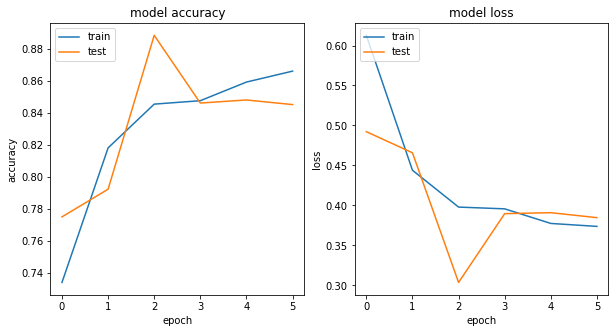

In [158]:
plot_acc_loss(history_fr)

Confusion Matrix for french dataset


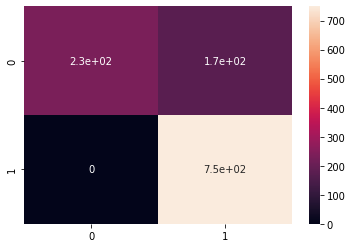

In [159]:
print("Confusion Matrix for french dataset")
Xtestfr = [np.asarray(X_test_fr1), np.asarray(X_test_fr2)]
plot_cm(model_fr,Xtestfr,y_test_fr)

In [160]:
test_loss, test_acc = model_fr.evaluate(Xtestfr,y_test_fr.astype(np.float32))
print('Test accuracy:', test_acc)

37/37 [==============================] - 1s 17ms/step - loss: 0.3758 - accuracy: 0.8496
Test accuracy: 0.8496110439300537


In [161]:
pred_fr =predicted_label(model_fr,Xtestfr)
# accuracy: (tp + tn) / (p + n)
accuracy_fr = accuracy_score(list(y_test_fr), pred_fr)
print('Accuracy: %f' % accuracy_fr)
# precision tp / (tp + fp)
precision_fr = precision_score(list(y_test_fr), pred_fr)
print('Precision: %f' % precision_fr)
# recall: tp / (tp + fn)
recall_fr = recall_score(list(y_test_fr), pred_fr)

print('Recall: %f' % recall_fr)
# f1: 2 tp / (2 tp + fp + fn)
f1_fr = f1_score(list(y_test_fr), pred_fr)
print('F1 score: %f' % f1_fr)


Accuracy: 0.849611
Precision: 0.811484
Recall: 1.000000
F1 score: 0.895933
